# Исследование надежности заемщиков банка

Заказчик — кредитный отдел банка. Задача разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

**План.**

1. [Загрузка данных и изучение общей информации.](#section_id_1)
2. [Предобработка данных.](#section_id_2)</br>
* 2.1. Удаление пропусков.</br>
* 2.2. Обработка аномальных значений.</br>
* 2.3. Удаление пропусков (продолжение).</br>
* 2.4. Изменение типов данных.</br>
* 2.5. Обработка дубликатов.</br>
* 2.6. Категоризации данных.</br>

3. [Исследовательский анализ.](#section_id_3)</br>
* 3.1. Есть ли зависимость между количеством детей и возвратом кредита в срок?</br>
* 3.2. Существует ли зависимость между семейным положением и возвратом кредита в срок?</br>
* 3.3. Есть ли зависимость между уровнем дохода и возвратом кредита в срок?</br>
* 3.4. Как разные цели кредита влияют на его возврат в срок?</br>

4. [Общий вывод.](#section_id_4)

**Описание данных**
* `children` - количество детей в семье
* `days_employed` - общий трудовой стаж в днях
* `dob_years` - возраст клиента в годах
* `education` - уровень образования клиента
* `education_id` - идентификатор уровня образования
* `family_status` - семейное положение
* `family_status_id` - идентификатор семейного положения
* `gender` - пол клиента
* `income_type` - тип занятости
* `debt` - имел ли задолженность по возврату кредитов
* `total_income` - ежемесячный доход
* `purpose` - цель получения кредита

## 1. Загрузка данных и изучение общей информации.<a id='section_id_1'></a>

**Путь к файлу:**

`/datasets/data.csv`

Датасет содержит данные о клиентах банка. Загрузим необходимые библиотеки, загрузим датасет и изучим общую информацию.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
try:
    data = pd.read_csv('/datasets/data.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/data.csv')

In [3]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


## 2. Предобработка данных.<a id='section_id_2'></a>

### 2.1. Удаление пропусков

* Выведем количество пропущенных значений для каждого столбца.

In [5]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

* В двух столбцах есть пропущенные значения. Один из них — `total_income`. Столбец `total_income` хранит данные о доходах. На сумму дохода сильнее всего влияет тип занятости, поэтому заполнить пропуски в этом столбце нужно медианным значением по каждому типу из столбца `income_type`. Столбец `days_employed` рассмотрим ниже.

In [6]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 'total_income'] = \
    data.loc[(data['income_type'] == t), 'total_income'].median()

### 2.2. Обработка аномальных значений

* Проверим данные на артефакты в столбце `days_employed`. Заменим все отрицательные значения положительными с помощью метода `abs()`.

In [7]:
data['days_employed'] = data['days_employed'].abs()

* Для каждого типа занятости выведем медианное значение трудового стажа `days_employed` в днях.

In [8]:
data.groupby('income_type')['days_employed'].agg('median')

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64

У двух типов (безработные и пенсионеры) получатся аномально большие значения. Исправить такие значения сложно, поэтому оставим их как есть. Тем более этот столбец не понадобится нам для исследования.

* Выведем перечень уникальных значений столбца `children`.

In [9]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5])

* В столбце `children` есть два аномальных значения. Удалим строки, в которых встречаются такие аномальные значения из датафрейма `data` и выведем перечень уникальных значений столбца `children`, чтобы убедиться, что артефакты удалены.

In [10]:
data = data[(data['children'] != -1) & (data['children'] != 20)]
data['children'].unique() 

array([1, 0, 3, 2, 4, 5])

### 2.3. Удаление пропусков (продолжение)

* Заполним пропуски в столбце `days_employed` медианными значениями по каждому типа занятости `income_type`.

In [11]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['days_employed'].isna()), 'days_employed'] = \
    data.loc[(data['income_type'] == t), 'days_employed'].median()

* Повторно выведем количество пропущенных значений для каждого столбца.

In [12]:
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

### 2.4. Изменение типов данных

* Заменим вещественный тип данных в столбце `total_income` на целочисленный с помощью метода `astype()`.

In [13]:
data['total_income'] = data['total_income'].astype(int)

### 2.5. Обработка дубликатов

* Обработаем неявные дубликаты в столбце `education`.

In [14]:
data['education'] = data['education'].str.lower()

* Определм количество строк-дубликатов.

In [15]:
data.duplicated().sum()

71

* Удалим строки-дубликаты.

In [16]:
data = data.drop_duplicates()

### 2.6. Категоризация данных

Создадим столбец `total_income_category` с категориями:

- 0–30000 — `'E'`;
- 30001–50000 — `'D'`;
- 50001–200000 — `'C'`;
- 200001–1000000 — `'B'`;
- 1000001 и выше — `'A'`.

In [17]:
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'E'
        elif 30001 <= income <= 50000:
            return 'D'
        elif 50001 <= income <= 200000:
            return 'C'
        elif 200001 <= income <= 1000000:
            return 'B'
        elif income >= 1000001:
            return 'A'
    except:
        pass

data['total_income_category'] = data['total_income'].apply(categorize_income)

* Выведем перечень уникальных целей взятия кредита из столбца `purpose`.

In [18]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Создадим функцию, которая на основании данных из столбца `purpose` сформирует новый столбец `purpose_category`, в который войдут следующие категории:**

- `'операции с автомобилем'`,
- `'операции с недвижимостью'`,
- `'проведение свадьбы'`,
- `'получение образования'`.

In [19]:
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'

data['purpose_category'] = data['purpose'].apply(categorize_purpose)

## 3. Исследовательский анализ.<a id='section_id_3'></a>

### 3.1. Есть ли зависимость между количеством детей и возвратом кредита в срок?

* Выведем на экран уникальные значения количества детей и посчитаем частоту встречаемости в таблице.

In [20]:
data.value_counts('children')

children
0    14091
1     4808
2     2052
3      330
4       41
5        9
dtype: int64

Чаще всего берут кредит клиенты не имеющие детей и с их ростом потенциальных клиентов становится меньше.

* Проверим нет ли аномальных сначений в столбце 'debt'.

In [21]:
print(len(data.loc[data['debt'] > 1]))
print(len(data.loc[data['debt'] < 0]))

0
0


* Сгруппируем таблицу по количеству детей и посчитаем среднее число-идентификатор задолженности клиентов в зависимости от численности семьи.

In [22]:
data.groupby('children')['debt'].mean()

children
0    0.075438
1    0.092346
2    0.094542
3    0.081818
4    0.097561
5    0.000000
Name: debt, dtype: float64

Клиенты, которые не стали ещё родителями реже всего задерживают платёж. Должниками оказываются новоиспечённые родители или клиенты, которые имеют 2 или 4 ребёнка. Родители троих детей немного реже становятся должниками. Исправными плательщиками становятся самые опытные родители. Посмотрим на них повнимательнее.

In [23]:
data.loc[data['children'] == 5]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category,purpose_category
3979,5,1572.328285,42,среднее,1,гражданский брак,1,M,сотрудник,0,142594,на покупку своего автомобиля,C,операции с автомобилем
4397,5,3248.839837,36,среднее,1,женат / замужем,0,F,компаньон,0,168460,операции с недвижимостью,C,операции с недвижимостью
7866,5,773.124856,36,среднее,1,женат / замужем,0,F,сотрудник,0,48772,операции с жильем,D,операции с недвижимостью
15822,5,418.199982,31,среднее,1,женат / замужем,0,F,сотрудник,0,77552,сделка с подержанным автомобилем,C,операции с автомобилем
15916,5,2286.262752,37,среднее,1,женат / замужем,0,F,сотрудник,0,256698,покупка недвижимости,B,операции с недвижимостью
16211,5,387.317579,35,среднее,1,гражданский брак,1,F,госслужащий,0,126102,на проведение свадьбы,C,проведение свадьбы
20452,5,268.425464,38,начальное,3,женат / замужем,0,F,сотрудник,0,212545,заняться высшим образованием,B,получение образования
20837,5,2386.600221,35,среднее,1,женат / замужем,0,F,компаньон,0,204241,жилье,B,операции с недвижимостью
21156,5,1690.018117,59,среднее,1,женат / замужем,0,M,сотрудник,0,269068,операции со своей недвижимостью,B,операции с недвижимостью


Такое большое количество детей имеют уже достаточно взрослые, ответственные люди. Чаще всего они женаты, имеют среднее образование и большую заработную плату.

* Поставим вопрос: какой процент клиентов в каждой категории стали должниками в ранее выданных кредитах?

In [24]:
data_percent = data.groupby('children').agg({'debt':['sum','count']})
def percent(axis):
    return (axis['sum']/axis['count'])*100
data_percent['percent'] = data_percent['debt'].apply(percent, axis = 1)
data_percent

debt          percent
           sum  count          
children                       
0         1063  14091  7.543822
1          444   4808  9.234609
2          194   2052  9.454191
3           27    330  8.181818
4            4     41  9.756098
5            0      9  0.000000

**Вывод:** Зависимость между количеством детей в семье и возвратом кредита в срок безусловно есть, но она не линейно зависит от числа детей. Реже всего становятся должниками бездетная категория клиентов. Семьи, которые имеют одного и более ребёнка, на 1-2% вероятнее задержат платёж. В нашем исследовании класс многодетной семьи сильно выбился из гипотезы. Данное отклонение можно объяснить тем, что выборка таких клиентов совсем небольшая (9 человек). Чаще всего они женаты, имеют среднее образование и большую заработную плату.

### 3.2. Существует ли зависимость между семейным положением и возвратом кредита в срок?

* Выведем на экран уникальные значения столбца `family_status` и посчитаем частоту встречаемости в таблице.

In [25]:
data.value_counts('family_status')

family_status
женат / замужем          12261
гражданский брак          4134
Не женат / не замужем     2796
в разводе                 1189
вдовец / вдова             951
dtype: int64

В таблице встречаются значения, написанные в разном регистре. Исправим их методом lower().

In [26]:
data['family_status'] = data['family_status'].str.lower()
data.value_counts('family_status')

family_status
женат / замужем          12261
гражданский брак          4134
не женат / не замужем     2796
в разводе                 1189
вдовец / вдова             951
dtype: int64

* Сгруппируем таблицу по семейному положению и посчитаем среднее число-идентификатор задолженности клиентов в зависимости от семейного статуса.

In [27]:
data.groupby('family_status')['debt'].mean()

family_status
в разводе                0.070648
вдовец / вдова           0.066246
гражданский брак         0.093130
женат / замужем          0.075606
не женат / не замужем    0.097639
Name: debt, dtype: float64

* Отсортируем выборку в порядке возрастания средней задолженности, выраженной в процентах.

In [28]:
data_family = data.groupby('family_status').agg({'debt':['sum','count']}).reset_index()
def family(axis):
    return (axis['sum']/axis['count'])*100
data_family['mean_debt'] = data_family['debt'].apply(family, axis = 1)
data_family = data_family.sort_values('mean_debt')
data_family.columns = ['family_status', 'sum_debt', 'count_debt', 'mean_debt']
data_family

,family_status,sum_debt,count_debt,mean_debt
1,вдовец / вдова,63,951,6.624606
0,в разводе,84,1189,7.064760
3,женат / замужем,927,12261,7.560558
2,гражданский брак,385,4134,9.313014
4,не женат / не замужем,273,2796,9.763948


* Построим столбчатую диаграмму зависимости среднего идентификатора задолженности (в %) от семейного положения.

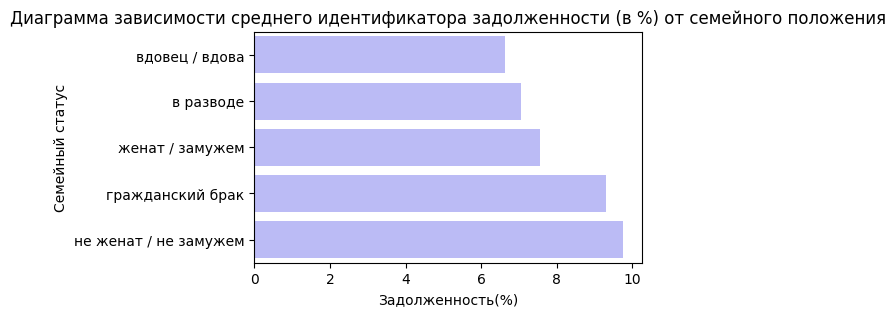

In [29]:
plt.figure(figsize=(5, 3))
sns.barplot(y='family_status',x='mean_debt',data = data_family, color='b', alpha=0.3)
plt.title('Диаграмма зависимости среднего идентификатора задолженности (в %) от семейного положения')
plt.xlabel('Задолженность(%)')
plt.ylabel('Семейный статус')
plt.show() 

**Вывод:** Зависимость между семейным положением клиентов и возвратом кредита в срок есть. Чаще всего задерживают платежи холостые клиенты. При вступлении в брак клиенты оказываются должниками немного реже. Самой малочисленной категорией по задержке кредитов оказались клиенты в разводе или потерявшие своего супруга.

### 3.3. Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Ранее мы разбивали доход клиентов по категориям, где
- доход 0–30000 — категория 'E';
- 30001–50000 — 'D';
- 50001–200000 — 'C';
- 200001–1000000 — 'B';
- 1000001 и выше — 'A'.

* Определим численность каждой категории.

In [30]:
data['total_income_category'].value_counts()

C    15921
B     5014
D      349
A       25
E       22
Name: total_income_category, dtype: int64

Большинство клиентов имеют доход от 50тыс до 200тыс, низкий доход (<50тыс) и высокий (>1млн) имеют немногие клиенты.

* Сгруппируем таблицу по категории дохода и посчитаем среднее число-идентификатор задолженности клиентов в зависимости от дохода.

In [31]:
data_category = data.groupby('total_income_category').agg({'debt':['mean']}).reset_index()
data_category.columns = ['total_income_category', 'debt_mean']
data_category['debt_mean']=data_category['debt_mean']*100
data_category

,total_income_category,debt_mean
0,A,8.000000
1,B,7.060231
2,C,8.498210
3,D,6.017192
4,E,9.090909


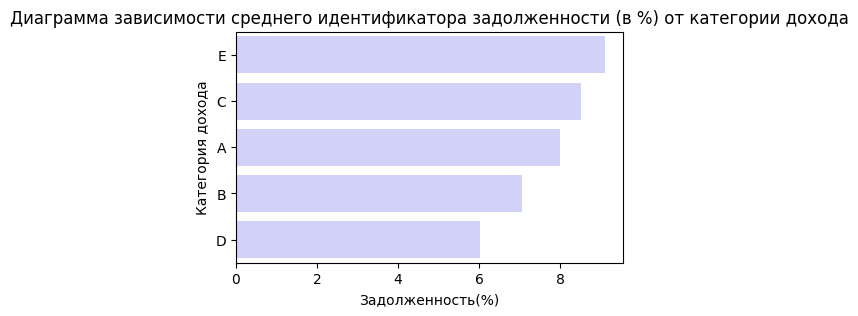

In [32]:
plt.figure(figsize=(5, 3))
sns.barplot(y='total_income_category',x='debt_mean',data = data_category.sort_values(by = 'debt_mean', ascending=False), 
            color='blue', alpha=0.2)
plt.title('Диаграмма зависимости среднего идентификатора задолженности (в %) от категории дохода')
plt.xlabel('Задолженность(%)')
plt.ylabel('Категория дохода')
plt.show() 

Заёмщики с доходом 30-50тыс. стараются погасить кредит в срок. Процент их задолжности ~6%. Клиенты с доходом 50-200тыс и до 30тыс. рублей имеют самый высокий процент задолженности в банке.

* Построим повнимательнее на наиболее многочисленную категорию клиентов, то есть на клиентов со средним доходом. Разобъём их на подкатегории:
- доход 50001-70000 — категория `60`;
- 70001–90000 — `80`;
- 90001–110000 — `100`;
- 110001–130000 — `120` и т.д.

In [33]:
data_average = data.loc[data['total_income'] >= 50001]
data_average = data_average.loc[data['total_income'] <= 209964]
def categorize_income(income):
    try:
        if 50001 <= income <= 70000:
            return '60'
        elif 70001 <= income <= 90000:
            return '80'
        elif 90001 <= income <= 110000:
            return '100'
        elif 110001 <= income <= 130000:
            return '120'
        elif 130001 <= income <= 150000:
            return '140'
        elif 150001 <= income <= 170000:
            return '160'
        elif 170001 <= income <= 190000:
            return '180'
        elif 190001 <= income <= 210000:
            return '200'
    except:
        pass
    
data_average['total_income_average_category'] = data_average['total_income'].apply(categorize_income)
data_average.sort_values(by='total_income').head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category,purpose_category,total_income_average_category
12944,1,715.177180,43,среднее,1,женат / замужем,0,M,сотрудник,0,50025,получение высшего образования,C,получение образования,60
15365,0,331511.396390,53,среднее,1,женат / замужем,0,F,пенсионер,0,50097,заняться высшим образованием,C,получение образования,60
15461,0,371258.560514,66,высшее,0,женат / замужем,0,F,пенсионер,0,50135,покупка жилья для семьи,C,операции с недвижимостью,60
2421,0,399346.699131,61,высшее,0,женат / замужем,0,M,пенсионер,0,50149,покупка коммерческой недвижимости,C,операции с недвижимостью,60
14688,1,148.516486,48,среднее,1,женат / замужем,0,F,сотрудник,0,50160,получение высшего образования,C,получение образования,60


* Сгруппируем таблицу по категориям среднего дохода и посчитаем среднее число-идентификатор задолженности клиентов, выраженное в процентах.

In [34]:
data_average.groupby('total_income_average_category')['debt'].mean()*100

total_income_average_category
100    8.450088
120    8.433283
140    8.962986
160    8.809524
180    8.073582
200    8.279743
60     7.136322
80     8.614232
Name: debt, dtype: float64

**Вывод:** Из анализа можно сделать вывод, что процент задолжности высок у клиентов с категориями дохода С и Е, то есть с доходом 50-200тыс. и до 30тыс. рублей. Рассмотрев заёмщиклв со средним заработком в 50-200тыс. руб., можно сказать что задолженность слабо зависит от уровня дохода внутри данной группы. 

### 3.4. Как разные цели кредита влияют на его возврат в срок?

* Ранее мы группировали цели на общие категории. Выведем на экран данные выборки.

In [35]:
data['purpose_category'].unique()

array(['операции с недвижимостью', 'операции с автомобилем',
       'получение образования', 'проведение свадьбы'], dtype=object)

* Посчитаем количество клиентов в каждой группе.

In [36]:
data.value_counts('purpose_category')

purpose_category
операции с недвижимостью    10751
операции с автомобилем       4279
получение образования        3988
проведение свадьбы           2313
dtype: int64

Чаще всего берут кредит на операции с недвижимостью, реже всего на проведение свадьбы, средние показатели имеют операции с автомобилем и кредиты на получение образования.

* Посчитаем среднюю задолженность в каждой из категорий.

In [37]:
data.groupby('purpose_category')['debt'].mean()*100

purpose_category
операции с автомобилем      9.347978
операции с недвижимостью    7.255139
получение образования       9.252758
проведение свадьбы          7.911803
Name: debt, dtype: float64

**Вывод:** Чаще всего задерживают выплату кредита клиенты, цель которых операции с автомобилем и получение образования. Из анализа так же видно, что такие классы считаются как средние по количеству клиентов с данными целями. Реже всего задерживают кредит малочисленная и многочисленная категории: операции с недвижимостью и проведение свадьбы.

## 4. Общий вывод.<a id='section_id_4'></a>

Мы исследовали как наличие детей, семейное положение, уровень дохода клиента и цель кредита могут влиять на погашение кредита в срок. Опишем каждый факт отдельно.

* **Наличие детей.**
Реже всего становятся должниками бездетная категория клиентов. Семьи, которые имеют одного и более ребёнка, на 1-2% вероятнее задержат платёж. В нашем исследовании класс многодетых семей сильно выбился из гипотезы. Данное отклонение можно объяснить тем, что выборка таких клиентов совсем небольшая (9 человек). Чаще всего они женаты, имеют среднее образование и большую заработную плату. Можно сказать что наличие детей негативно сказывается на способность клиентов покрыть кредит в срок.

* **Семейное положение.**
Холостые клиенты оказались менее надёжными заёмщиками. При вступлении в брак клиенты оказываются должниками немного реже. Самой малочисленной категорией по задержке кредитов оказались клиенты в разводе или потерявшие своего супруга.

* **Уровень дохода.**
Из анализа можно сделать вывод, что задолженность клиентов слабо зависит от уровня доходов, однако клиенты с низким и средним уровнем дохода оказываются менее стабильными в выплатах. Средний процент задержки кредита оказался ~6-9%.

* **Цель кредита.**
При категоризации было обнаружено, что группы "операции с автомобилем" и "получение образования" средние по частоте взятия кредита, но так же на них приходится большой процент задержки кредита. Самой многочисленной оказалась цель "операция с недвижимостью", малочисленной - "проведение свадьбы". Выяснилось, что клиенты из данных категорий самые ответственные.